## Car Price prediction using linear regression from scratch

### About
The car price predction project is developed as part of my learnings from the [Data talks club ml zoomcamp](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html) organized by [Alexey Grigorev](https://twitter.com/Al_Grigor). The project is about predicting the car prices based on the features provided in the dataset using pandas and numpy library. This project does not inlcude use of sci-kit learn and the linear regression model is developed from scratch along with the validation metric.

### Dataset
The dataset is taken from Kaggle and is available at this [link](https://www.kaggle.com/datasets/CooperUnion/cardataset)

### Contentes
- Data Preparation
- Exploratory Data Analysis
- Validation framework creation
- Linear Regression 
- Baseline solution
- Simple Feature Engineering
- Regulariation
- Using the model

### Data Preparation

First we will import the necessary libraries like python, numpy, seaborn and matplotlib.

In [238]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Reading the data into a dataframe and having a look at the data

In [239]:
df = pd.read_csv('..\datasets\Car-Price-Dataset.csv')
df.shape

(11914, 16)

In [240]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Exploratory Data Analysis

We observe that there are many inconsistencies with the column name and the string values in the columns. So we will convert all the column names to lowercase and replace any spaces in between with '_' and will do the same for the values in those columns.

In [241]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [242]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


# Exploratory Data Analysis

Let's first explore the distribution of msrp which is our target value by plotting a graph

Text(0.5, 1.0, 'Price Distribution (MSRP)')

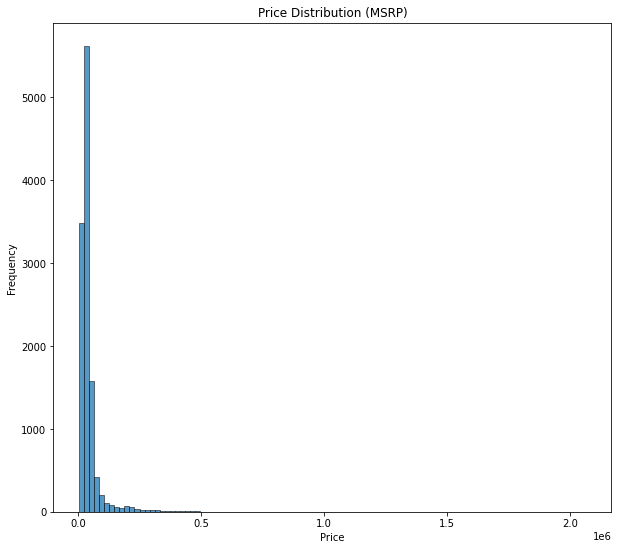

In [243]:
plt.figure(figsize=(10, 9))

sns.histplot(df.msrp, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Price Distribution (MSRP)')


From above we can see the distribution is a long-tail distribution and most of the data is to the left side of the graph. Now lets take a look at the msrp values less then 100000 where most of the data lies.

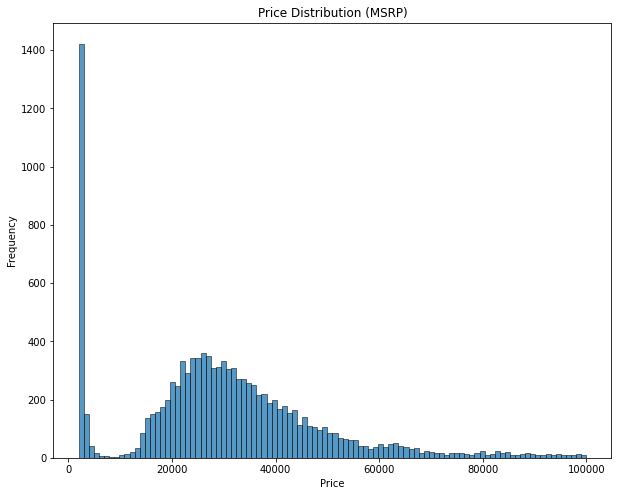

In [244]:
plt.figure(figsize=(10, 8))

sns.histplot(df.msrp[df.msrp < 100000], bins=100)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Price Distribution (MSRP)')

plt.show()

Now we can see that the data is roughly in a bell shaped curve. But the overall data has a very high variance which will affect our accuracy in predicting the prices so to overcome that we will use log values of the msrp to train our model which will generate more accurate prediction.

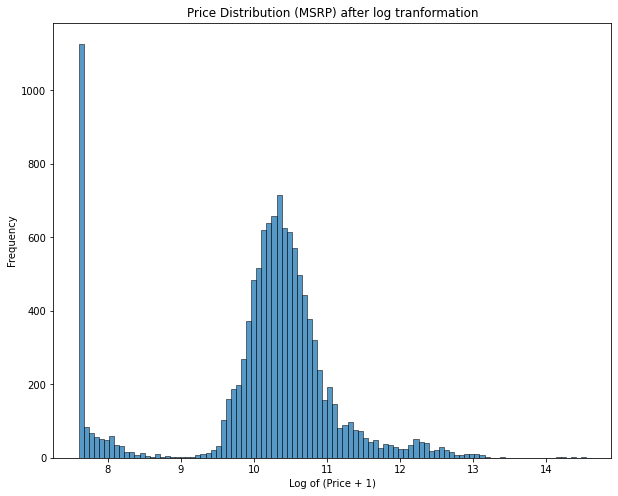

In [245]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(10, 8))

sns.histplot(log_price, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Log of (Price + 1)')
plt.title('Price Distribution (MSRP) after log tranformation')

plt.show()

Now let's check the number of null values present in each column of dataframe

In [246]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

We can see there are couple of column having null values and we have to handle them. One way is to remove the null value rows or use mean, median or mode to fill the values. The other is to put 0 in place of null values which is ideal for this case. So we will do that when we will prepare our X values later.

# Validation framework

We will divide the data into 3 parts in 60:20:20 ratio. We will use 60% of the data for training, 20% for validation and rest 20% for testing our model performance. We will shuffle the rows such that there won't be any sampling bias and then we will split the data. 

In [247]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

we will seperate out the target column and store it in y variable for all train, validate and test dataframe. We will just store the values of target column instead of the dataframe. We will store the target value in two forms, one will be the original values and other will be the log values to generate predicitons and validate the model. 

In [248]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values) 
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Linear Regression

We will create our linear regression function to generate predictions. Check [here]('https://github.com/ugoswami11/ml-course-bootcamp/blob/main/notes/regression.md') for detailed explaination of linear regression equation. The below function train_linear_regression will return w0 (weight bias term) and W(feature weights) value which we will be required for the linear regression equation. 

In [249]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Baseline solution

We will try to generate prediciton using some basic features

In [250]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

We will create a prepare_X function to generate our X matrix which will contain the feature column values.

In [251]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [252]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

we will store our generated prediction in y_pred and will plot a graph of the predicted values and original values to check how far we are from our target.

In [253]:
y_pred = w0 + X_train.dot(w)

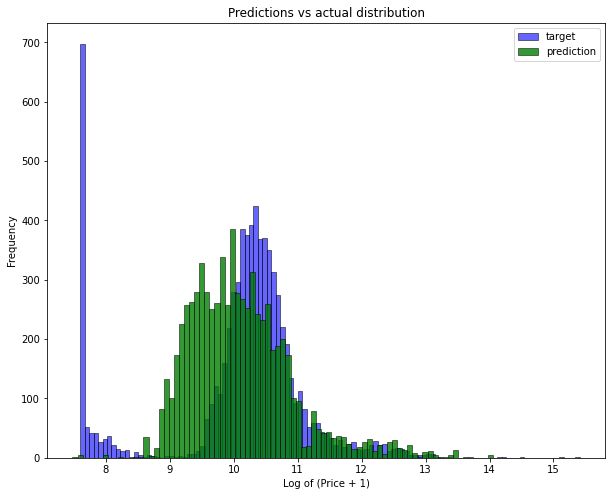

In [254]:
plt.figure(figsize=(10, 8))

sns.histplot(y_train, label='target', color='blue', alpha=0.6, bins=100)
sns.histplot(y_pred, label='prediction', color='green', alpha=0.8, bins=100)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log of (Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

We can also use some evaluation metrics like RMSE score to determine how good our prediction is. We will create our own RMSE function and define it to evaluate our predicted values.

In [255]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [256]:
rmse(y_train, y_pred)

0.7554192603920132

In the previous step we calculated our weights from X train and y train values and generated a prediction. Now that we trained our model on training datasets we will use the weight values of training dataset and generate prediction on our validation dataset which will give us an idea how well the model will perform in real world.

In [257]:
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

In [258]:
rmse(y_val, y_pred)

0.761653099130156

# Simple Feature Engineering

We have evaluated our model with some basic features and now it's time to do some feature engineering and including the rest of the features to generate better predictions.
We will create a new feature age from the existing year column and will check how the model has improved.

In [259]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [260]:

X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.5175055465840046
validation 0.5172055461058299


We can clearly see from the RMSE scores that there is a slight improvement in the performane of the model. We can also plot a graph to visulaize the same.

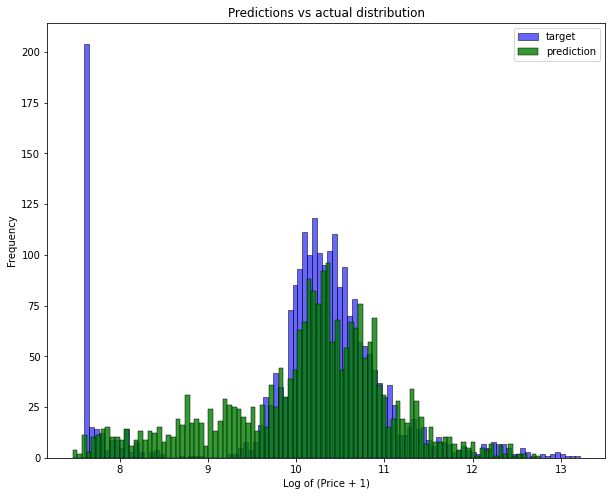

In [261]:
plt.figure(figsize=(10, 8))


sns.histplot(y_val, label='target', color='blue', alpha=0.6, bins=100)
sns.histplot(y_pred, label='prediction', color='green', alpha=0.8, bins=100)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log of (Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

We will add some more featuers like number of doors and the make column values, but these are categorical columns so first we need to convert it to numerical value then only we can use this values.
For number of doors column it has numerical values but that column is categorical column as we have only 3 kinds of values in it so we will create 3 seperate column for each category.
Similarly for make column we will take the first 10 categories which has the highest count in the column and convert it into 10 different columns.

In [262]:
df['number_of_doors'].unique()

array([ 2.,  4.,  3., nan])

In [263]:
df['make'].value_counts().head(10)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
nissan         558
gmc            515
honda          449
mazda          423
cadillac       397
Name: make, dtype: int64

In [264]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = f'num_doors_{v}'
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge','nissan','gmc','honda','mazda','cadillac']:
        feature = f'is_make_{v}'
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [265]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.4973215500895837
validation: 0.5008499503020907


we can observe from above that there is a slight improvement in score so we will keep on adding other features and evaluate our model performance

We will now look and the engine fuel type column, there are around 10 categories so we can include all of them but I'm taking the first 8 as the last two have very low count in the column and we will convert them into 8 numerical columns.

In [266]:
df['engine_fuel_type'].value_counts()

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [267]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = f'num_doors_{v}'
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = f'is_make_{v}'
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)','diesel','electric',
              'flex-fuel_(premium_unleaded_required/e85)','flex-fuel_(premium_unleaded_recommended/e85)',
              ]:
        feature = f'is_type_{v}'
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [268]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.475175914378416
validation: 0.47021651262215763


We observe that our model has again improved in performance. Similarly we will keep on adding other columns.

Now we will look at the transmission type column, there are 5 unique values in that column, I will use the first 4 as the last one has very low count.

In [269]:
df['transmission_type'].value_counts()

automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: transmission_type, dtype: int64

In [270]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = f'num_doors_{v}'
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = f'is_make_{v}'
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = f'is_type_{v}'
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual','direct_drive']:
        feature = f'is_transmission_{v}'
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [271]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.47033260998829546
validation: 0.465656953042426


Now let's add the remaining column as features and see how the prediction score differs.

In [272]:
df['driven_wheels'].value_counts()

front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: driven_wheels, dtype: int64

In [273]:
df['market_category'].value_counts().head(10)

crossover                  1110
flex_fuel                   872
luxury                      855
luxury,performance          673
hatchback                   641
performance                 601
crossover,luxury            410
luxury,high-performance     334
exotic,high-performance     261
hatchback,performance       252
Name: market_category, dtype: int64

In [274]:
df['vehicle_size'].value_counts()

compact    4764
midsize    4373
large      2777
Name: vehicle_size, dtype: int64

In [275]:
df['vehicle_style'].value_counts().head(10)

sedan                  3048
4dr_suv                2488
coupe                  1211
convertible             793
4dr_hatchback           702
crew_cab_pickup         681
extended_cab_pickup     623
wagon                   592
2dr_hatchback           506
passenger_minivan       417
Name: vehicle_style, dtype: int64

In [276]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = f'num_doors_{v}'
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = f'is_make_{v}'
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = f'is_type_{v}'
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = f'is_transmission_{v}'
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = f'is_driven_wheens_{v}'
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = f'is_mc_{v}'
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = f'is_size_{v}'
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = f'is_style_{v}'
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [277]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 113.1789516729169
validation: 55.21320990769284


# Regularization

From last RMSE score we can observe that the performance got worse for the model. So we will tune the model using regularization and will try to add some more categories for some column to improve performance.

Click [here]('https://github.com/ugoswami11/ml-course-bootcamp/blob/main/notes/regression.md') to check the detailed explaination of Regularization.

In [278]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

Lets check for different values of r how the model performs. lets first check with 0 and 0.01

In [279]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0)

y_pred = w0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 113.1789516729169
val 55.21320990769284


In [280]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.4643124894564607
val 0.4602394963121961


Now lets add some more categories for market and vehicle style column to improve the rmse score

In [281]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = f'num_doors_{v}'
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = f'is_make_{v}'
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = f'is_type_{v}'
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = f'is_transmission_{v}'
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = f'is_driven_wheens_{v}'
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback'
             'performance,crossover','luxury', 'luxury,high-performance', 'exotic,high-performance', 'hatchback,performance']:
        feature = f'is_mc_{v}'
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = f'is_size_{v}'
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback'
             'crew_cab_pickup', 'extended_cab_pickup', 'wagon', '2dr_hatchback', 'passenger_minivan']:
        feature = f'is_style_{v}'
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

Let's try on differnet values for r and we will take the values of r which has the best rmse score.

In [282]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.45071177901986803
0.0001 0.4507122830932217
 0.001 0.45071374140839315
  0.01 0.45072838559591144
   0.1 0.4508776301722032
     1 0.4525040468715849
     5 0.45981746786455907
    10 0.46806004730961737


So we can see for few of the values of r the performance is almost similar, so lets use 0.01 as the value of r and test our model on the test dataset to get an idea how it will perform in real world.

In [283]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.45072838559591144
test: 0.4463855733935629


Now lets concatenate our train dataset with validation dataset and generate prediction then test it on the test dataset to improve our model performance 

In [284]:
df_full_train = pd.concat([df_train, df_val], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)

In [285]:
df_full_train = df_full_train.reset_index(drop=True)

In [286]:
df_full_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031
2,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640
3,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873
4,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657


In [287]:
df_full_train.shape

(9532, 15)

In [288]:
len(y_full_train)

9532

In [289]:
X_train = prepare_X(df_full_train)
w0, w = train_linear_regression_reg(X_train, y_full_train, r=0.01)

y_pred = w0 + X_train.dot(w)
print('full train:', rmse(y_full_train, y_pred))

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

full train: 0.4539158688754138
test: 0.4451355570203033


Finally lets generate plot with our prediction values and target values 

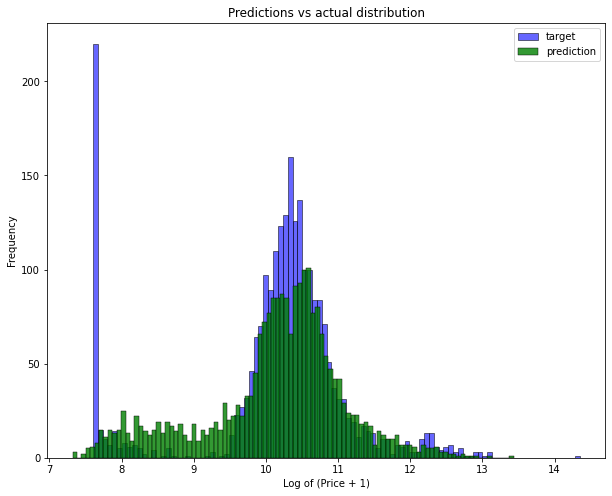

In [290]:
plt.figure(figsize=(10,8))

sns.histplot(y_test, label='target', color='blue', alpha=0.6, bins=100)
sns.histplot(y_pred, label='prediction', color='green', alpha=0.8, bins=100)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log of (Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

# Using the model

Now we will just take one row from test dataframe and try out how accurate prices is being predicted by the column.

In [291]:
i = 2
data = df_test.iloc[i].to_dict()
data

{'make': 'toyota',
 'model': 'venza',
 'year': 2013,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 268.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'all_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'crossover,performance',
 'vehicle_size': 'midsize',
 'vehicle_style': 'wagon',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [292]:
y_test_orig[i]

31120

In [293]:
X_test_model = prepare_X(pd.DataFrame([data]))[0]
y_pred_model = w0 + X_test_model.dot(w)
price_suggestion = np.expm1(y_pred_model)
price_suggestion

30143.57961677373